<a href="https://colab.research.google.com/github/sauravsingla/NLP/blob/master/NLP_Recommender_System_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install libnvrtc8.0
!pip uninstall -y mxnet-cu80 && pip install mxnet-cu80==1.1.0
!pip install turicreate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
Skipping mxnet-cu80 as it is not installed.
    100% |████████████████████████████████| 274.9MB 66kB/s 
    100% |████████████████████████████████| 17.0MB 2.3MB/s 
yellowbrick 0.9 has requirement matplotlib<3.0,>=1.5.1, but you'll have matplotlib 3.0.2 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.0 which is incompatible.
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.13.3 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.1 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cvxpy 1.0.11 has requirement numpy>=1.14, but you'll have numpy 1.13.3 which is incompa

In [ ]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os.path
import urllib.request
import tarfile
import zipfile
import gzip
from shutil import copy

def fetch_remote_datafile(filename, remote_url):
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
    return
  print("fetching " + filename + " from " + remote_url + "...")
  urllib.request.urlretrieve(remote_url, "./" + filename)

def cache_datafile_in_drive(filename):
  if os.path.isfile("./" + filename) == False:
    print("cannot cache " + filename + ", it is not in workspace")
    return
  
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile(data_drive_path + filename):
    print("" + filename + " has already been stored in Google Drive")
  else:
    print("copying " + filename + " to " + data_drive_path)
    copy("./" + filename, data_drive_path)
  

def load_datafile_from_drive(filename, remote_url=None):
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
  elif os.path.isfile(data_drive_path + filename):
    print("have " + filename + " in Google Drive, copying to workspace...")
    copy(data_drive_path + filename, ".")
  elif remote_url != None:
    fetch_remote_datafile(filename, remote_url)
  else:
    print("error: you need to manually download " + filename + " and put in drive")
    
def extract_datafile(filename, expected_extract_artifact=None):
  if expected_extract_artifact != None and (os.path.isfile(expected_extract_artifact) or os.path.isdir(expected_extract_artifact)):
    print("files in " + filename + " have already been extracted")
  elif os.path.isfile("./" + filename) == False:
    print("error: cannot extract " + filename + ", it is not in the workspace")
  else:
    extension = filename.split('.')[-1]
    if extension == "zip":
      print("extracting " + filename + "...")
      data_file = open(filename, "rb")
      z = zipfile.ZipFile(data_file)
      for name in z.namelist():
          print("    extracting file", name)
          z.extract(name, "./")
      data_file.close()
    elif extension == "gz":
      print("extracting " + filename + "...")
      if filename.split('.')[-2] == "tar":
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
      else:
        data_zip_file = gzip.GzipFile(filename, 'rb')
        data = data_zip_file.read()
        data_zip_file.close()
        extracted_file = open('.'.join(filename.split('.')[0:-1]), 'wb')
        extracted_file.write(data)
        extracted_file.close()
    elif extension == "tar":
      print("extracting " + filename + "...")
      tar = tarfile.open(filename)
      tar.extractall()
      tar.close()
    elif extension == "csv":
      print("do not need to extract csv")
    else:
      print("cannot extract " + filename)
      
def load_cache_extract_datafile(filename, expected_extract_artifact=None, remote_url=None):
  load_datafile_from_drive(filename, remote_url)
  extract_datafile(filename, expected_extract_artifact)
  cache_datafile_in_drive(filename)
  

In [ ]:
load_cache_extract_datafile("ml-20m.zip", "ml-20m", "http://files.grouplens.org/datasets/movielens/ml-20m.zip")

In [ ]:
import mxnet as mx
import turicreate as tc

In [ ]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [ ]:
actions = tc.SFrame.read_csv('./ml-20m/ratings.csv')
actions.head()

Finished parsing file /content/ml-20m/ratings.csv

Parsing completed. Parsed 100 lines in 1.25749 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 2042753 lines. Lines per second: 939287

Read 11940935 lines. Lines per second: 1.64674e+06

Finished parsing file /content/ml-20m/ratings.csv

Parsing completed. Parsed 20000263 lines in 10.6544 secs.

userId,movieId,rating,timestamp
1,2,3.5,1112486027
1,29,3.5,1112484676
1,32,3.5,1112484819
1,47,3.5,1112484727
1,50,3.5,1112484580
1,112,3.5,1094785740
1,151,4.0,1094785734
1,223,4.0,1112485573
1,253,4.0,1112484940
1,260,4.0,1112484826


In [ ]:
actions.groupby('userId', [tc.aggregate.COUNT]).sort("Count", ascending = False)

userId,Count
118205,9254
8405,7515
82418,5646
121535,5520
125794,5491
74142,5447
34576,5356
131904,5330
83090,5169
59477,4988


In [ ]:
items = tc.SFrame.read_csv('./ml-20m/movies.csv')
items.head()

Finished parsing file /content/ml-20m/movies.csv

Parsing completed. Parsed 100 lines in 0.078739 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/ml-20m/movies.csv

Parsing completed. Parsed 27278 lines in 0.040305 secs.

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...
2,Jumanji (1995),Adventure|Children|Fantasy ...
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride PartII (1995) ...,Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
training_data, validation_data = tc.recommender.util.random_split_by_user(actions, 'userId', 'movieId')

In [ ]:
model = tc.recommender.create(training_data, 'userId', 'movieId')

Warning: Ignoring columns rating, timestamp;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 19970212 observations with 138493 users and 26657 items.

Data prepared in: 16.0448s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 11.215ms                       | 0.5        |

| 558.65ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.00s                               | 0                | 0               |

| 5.00s                               | 2                | 548             |

| 8.00s                               | 3.5              | 996             |

| 11.04s                              | 5.5              | 1483            |

| 14.05s                              | 7.25             | 1988            |

| 17.00s                              | 8.75             | 2398            |

| 20.00s                              | 10.5             | 2839            |

| 23.00s                              | 12.25            | 3329            |

| 26.00s                              | 14.25            | 3812            |

| 29.00s                              | 15.75            | 4241            |

| 32.06s                              | 17.5             | 4686            |

| 35.00s                              | 19               | 5094            |

| 38.00s                              | 20.75            | 5583            |

| 41.00s                              | 22.5             | 6015            |

| 44.00s                              | 24               | 6456            |

| 47.03s                              | 25.75            | 6881            |

| 50.00s                              | 27.25            | 7304            |

| 53.00s                              | 29               | 7749            |

| 56.00s                              | 30.5             | 8184            |

| 59.00s                              | 32.25            | 8628            |

| 1m 2s                               | 34               | 9097            |

| 1m 5s                               | 35.5             | 9513            |

| 1m 8s                               | 37.25            | 9954            |

| 1m 11s                              | 38.75            | 10362           |

| 1m 14s                              | 40.25            | 10794           |

| 1m 17s                              | 42               | 11218           |

| 1m 20s                              | 43.5             | 11639           |

| 1m 23s                              | 45               | 12060           |

| 1m 26s                              | 46.75            | 12490           |

| 1m 29s                              | 48.25            | 12921           |

| 1m 32s                              | 50               | 13372           |

| 1m 35s                              | 51.75            | 13845           |

| 1m 38s                              | 53.25            | 14259           |

| 1m 41s                              | 55               | 14697           |

| 1m 44s                              | 56.5             | 15111           |

| 1m 47s                              | 58.25            | 15545           |

| 1m 50s                              | 59.75            | 15960           |

| 1m 53s                              | 61.25            | 16380           |

| 1m 56s                              | 63               | 16811           |

| 1m 59s                              | 64.5             | 17227           |

| 2m 2s                               | 66               | 17643           |

| 2m 5s                               | 67.75            | 18073           |

| 2m 8s                               | 69.25            | 18499           |

| 2m 11s                              | 71.25            | 19004           |

| 2m 14s                              | 72.75            | 19424           |

| 2m 17s                              | 74.5             | 19894           |

| 2m 20s                              | 76.25            | 20333           |

| 2m 23s                              | 77.75            | 20758           |

| 2m 26s                              | 79.25            | 21186           |

| 2m 29s                              | 81               | 21607           |

| 2m 32s                              | 82.75            | 22059           |

| 2m 35s                              | 84.25            | 22478           |

| 2m 38s                              | 85.75            | 22922           |

| 2m 41s                              | 87.5             | 23337           |

| 2m 44s                              | 89               | 23780           |

| 2m 47s                              | 90.75            | 24251           |

| 2m 50s                              | 92.5             | 24681           |

| 2m 53s                              | 94               | 25119           |

| 2m 56s                              | 95.75            | 25540           |

| 2m 59s                              | 97.25            | 25983           |

| 3m 2s                               | 99               | 26429           |

| 3m 11s                              | 100              | 26657           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 193.673s

In [ ]:
results = model.recommend()

recommendations finished on 1000/138493 queries. users per second: 2917.41

recommendations finished on 2000/138493 queries. users per second: 2921.47

recommendations finished on 3000/138493 queries. users per second: 2936.69

recommendations finished on 4000/138493 queries. users per second: 2935.25

recommendations finished on 5000/138493 queries. users per second: 2932.59

recommendations finished on 6000/138493 queries. users per second: 2785.59

recommendations finished on 7000/138493 queries. users per second: 2665.66

recommendations finished on 8000/138493 queries. users per second: 2581.26

recommendations finished on 9000/138493 queries. users per second: 2519.03

recommendations finished on 10000/138493 queries. users per second: 2474.95

recommendations finished on 11000/138493 queries. users per second: 2438.44

recommendations finished on 12000/138493 queries. users per second: 2408.19

recommendations finished on 13000/138493 queries. users per second: 2385.1

recommendations finished on 14000/138493 queries. users per second: 2360.14

recommendations finished on 15000/138493 queries. users per second: 2344.09

recommendations finished on 16000/138493 queries. users per second: 2326.82

recommendations finished on 17000/138493 queries. users per second: 2314.04

recommendations finished on 18000/138493 queries. users per second: 2301.04

recommendations finished on 19000/138493 queries. users per second: 2290.58

recommendations finished on 20000/138493 queries. users per second: 2277.58

recommendations finished on 21000/138493 queries. users per second: 2269.54

recommendations finished on 22000/138493 queries. users per second: 2261.27

recommendations finished on 23000/138493 queries. users per second: 2255.25

recommendations finished on 24000/138493 queries. users per second: 2248.61

recommendations finished on 25000/138493 queries. users per second: 2243.23

recommendations finished on 26000/138493 queries. users per second: 2238.76

recommendations finished on 27000/138493 queries. users per second: 2231.74

recommendations finished on 28000/138493 queries. users per second: 2227.56

recommendations finished on 29000/138493 queries. users per second: 2222.45

recommendations finished on 30000/138493 queries. users per second: 2219.62

recommendations finished on 31000/138493 queries. users per second: 2214.86

recommendations finished on 32000/138493 queries. users per second: 2211.36

recommendations finished on 33000/138493 queries. users per second: 2207.9

recommendations finished on 34000/138493 queries. users per second: 2204.56

recommendations finished on 35000/138493 queries. users per second: 2201.24

recommendations finished on 36000/138493 queries. users per second: 2199.36

recommendations finished on 37000/138493 queries. users per second: 2194.95

recommendations finished on 38000/138493 queries. users per second: 2192.64

recommendations finished on 39000/138493 queries. users per second: 2190.81

recommendations finished on 40000/138493 queries. users per second: 2188.31

recommendations finished on 41000/138493 queries. users per second: 2186.06

recommendations finished on 42000/138493 queries. users per second: 2184.11

recommendations finished on 43000/138493 queries. users per second: 2182.76

recommendations finished on 44000/138493 queries. users per second: 2180.54

recommendations finished on 45000/138493 queries. users per second: 2179.63

recommendations finished on 46000/138493 queries. users per second: 2177.19

recommendations finished on 47000/138493 queries. users per second: 2175.32

recommendations finished on 48000/138493 queries. users per second: 2173.31

recommendations finished on 49000/138493 queries. users per second: 2171.22

recommendations finished on 50000/138493 queries. users per second: 2168.25

recommendations finished on 51000/138493 queries. users per second: 2167.99

recommendations finished on 52000/138493 queries. users per second: 2166.51

recommendations finished on 53000/138493 queries. users per second: 2164.74

recommendations finished on 54000/138493 queries. users per second: 2164.14

recommendations finished on 55000/138493 queries. users per second: 2163.03

recommendations finished on 56000/138493 queries. users per second: 2162.71

recommendations finished on 57000/138493 queries. users per second: 2161.44

recommendations finished on 58000/138493 queries. users per second: 2160.08

recommendations finished on 59000/138493 queries. users per second: 2158.62

recommendations finished on 60000/138493 queries. users per second: 2158.36

recommendations finished on 61000/138493 queries. users per second: 2157.56

recommendations finished on 62000/138493 queries. users per second: 2156.8

recommendations finished on 63000/138493 queries. users per second: 2153.8

recommendations finished on 64000/138493 queries. users per second: 2153

recommendations finished on 65000/138493 queries. users per second: 2151.5

recommendations finished on 66000/138493 queries. users per second: 2151.45

recommendations finished on 67000/138493 queries. users per second: 2150.64

recommendations finished on 68000/138493 queries. users per second: 2150.14

recommendations finished on 69000/138493 queries. users per second: 2149.05

recommendations finished on 70000/138493 queries. users per second: 2148.22

recommendations finished on 71000/138493 queries. users per second: 2147.95

recommendations finished on 72000/138493 queries. users per second: 2147.08

recommendations finished on 73000/138493 queries. users per second: 2146.86

recommendations finished on 74000/138493 queries. users per second: 2145.81

recommendations finished on 75000/138493 queries. users per second: 2144.59

recommendations finished on 76000/138493 queries. users per second: 2143.81

recommendations finished on 77000/138493 queries. users per second: 2142.88

recommendations finished on 78000/138493 queries. users per second: 2141.74

recommendations finished on 79000/138493 queries. users per second: 2141.3

recommendations finished on 80000/138493 queries. users per second: 2140.56

recommendations finished on 81000/138493 queries. users per second: 2140.43

recommendations finished on 82000/138493 queries. users per second: 2139.86

recommendations finished on 83000/138493 queries. users per second: 2139.97

recommendations finished on 84000/138493 queries. users per second: 2140.17

recommendations finished on 85000/138493 queries. users per second: 2139.6

recommendations finished on 86000/138493 queries. users per second: 2139.52

recommendations finished on 87000/138493 queries. users per second: 2139.17

recommendations finished on 88000/138493 queries. users per second: 2139.13

recommendations finished on 89000/138493 queries. users per second: 2138.75

recommendations finished on 90000/138493 queries. users per second: 2138.63

recommendations finished on 91000/138493 queries. users per second: 2138.19

recommendations finished on 92000/138493 queries. users per second: 2138.15

recommendations finished on 93000/138493 queries. users per second: 2137.53

recommendations finished on 94000/138493 queries. users per second: 2137.2

recommendations finished on 95000/138493 queries. users per second: 2136.04

recommendations finished on 96000/138493 queries. users per second: 2136.03

recommendations finished on 97000/138493 queries. users per second: 2136.05

recommendations finished on 98000/138493 queries. users per second: 2135.78

recommendations finished on 99000/138493 queries. users per second: 2135.41

recommendations finished on 100000/138493 queries. users per second: 2134.96

recommendations finished on 101000/138493 queries. users per second: 2134.65

recommendations finished on 102000/138493 queries. users per second: 2134.28

recommendations finished on 103000/138493 queries. users per second: 2134.28

recommendations finished on 104000/138493 queries. users per second: 2133.86

recommendations finished on 105000/138493 queries. users per second: 2133.76

recommendations finished on 106000/138493 queries. users per second: 2133.42

recommendations finished on 107000/138493 queries. users per second: 2133.42

recommendations finished on 108000/138493 queries. users per second: 2133.04

recommendations finished on 109000/138493 queries. users per second: 2132.41

recommendations finished on 110000/138493 queries. users per second: 2132.49

recommendations finished on 111000/138493 queries. users per second: 2132.01

recommendations finished on 112000/138493 queries. users per second: 2131.81

recommendations finished on 113000/138493 queries. users per second: 2131.38

recommendations finished on 114000/138493 queries. users per second: 2130.93

recommendations finished on 115000/138493 queries. users per second: 2130.39

recommendations finished on 116000/138493 queries. users per second: 2130.29

recommendations finished on 117000/138493 queries. users per second: 2129.88

recommendations finished on 118000/138493 queries. users per second: 2129.95

recommendations finished on 119000/138493 queries. users per second: 2129.63

recommendations finished on 120000/138493 queries. users per second: 2129.73

recommendations finished on 121000/138493 queries. users per second: 2129.54

recommendations finished on 122000/138493 queries. users per second: 2129.4

recommendations finished on 123000/138493 queries. users per second: 2129.27

recommendations finished on 124000/138493 queries. users per second: 2129.2

recommendations finished on 125000/138493 queries. users per second: 2129.18

recommendations finished on 126000/138493 queries. users per second: 2129.13

recommendations finished on 127000/138493 queries. users per second: 2128.97

recommendations finished on 128000/138493 queries. users per second: 2129.13

recommendations finished on 129000/138493 queries. users per second: 2129.2

recommendations finished on 130000/138493 queries. users per second: 2128.85

recommendations finished on 131000/138493 queries. users per second: 2128.83

recommendations finished on 132000/138493 queries. users per second: 2128.71

recommendations finished on 133000/138493 queries. users per second: 2128.64

recommendations finished on 134000/138493 queries. users per second: 2128.39

recommendations finished on 135000/138493 queries. users per second: 2128.28

recommendations finished on 136000/138493 queries. users per second: 2128.13

recommendations finished on 137000/138493 queries. users per second: 2128.09

recommendations finished on 138000/138493 queries. users per second: 2125.04

In [ ]:
print(results)

+--------+---------+---------------------+------+
| userId | movieId |        score        | rank |
+--------+---------+---------------------+------+
|   1    |   1682  | 0.08997823068073818 |  1   |
|   1    |   2115  | 0.08676331315721784 |  2   |
|   1    |   1265  |  0.0837453978402274 |  3   |
|   1    |   3578  | 0.08367979458400181 |  4   |
|   1    |   1580  | 0.08304152931485857 |  5   |
|   1    |   1527  | 0.08159975562776837 |  6   |
|   1    |   2571  | 0.07946000269481114 |  7   |
|   1    |   1270  | 0.07488769633429392 |  8   |
|   1    |   3793  | 0.07287938560758318 |  9   |
|   1    |   5349  |  0.070350136416299  |  10  |
+--------+---------+---------------------+------+
[1384930 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [ ]:
for i in range(10):
  print(items[results["movieId"][i]==items["movieId"]])


+---------+-------------------------+---------------------+
| movieId |          title          |        genres       |
+---------+-------------------------+---------------------+
|   1682  | Truman Show, The (1998) | Comedy|Drama|Sci-Fi |
+---------+-------------------------+---------------------+
[? rows x 3 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.
+---------+-------------------------------+--------------------------+
| movieId |             title             |          genres          |
+---------+-------------------------------+--------------------------+
|   2115  | Indiana Jones and the Temp... | Action|Adventure|Fantasy |
+---------+-------------------------------+--------------------------+
[? rows x 3 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.
+---------+----------------------+-

In [ ]:
def print_favorite_movie(row):
  if row["rating"] > 4.0:
    print(items[row["movieId"]==items["movieId"]])

def print_movie(row):
  print(items[row["movieId"]==items["movieId"]])

In [ ]:
test_user_id = 7

In [ ]:
test_user_actions = actions[actions["userId"]==test_user_id].sort("rating", ascending = False)
print(test_user_actions.head())
test_user_actions.apply(print_favorite_movie)

+--------+---------+--------+------------+
| userId | movieId | rating | timestamp  |
+--------+---------+--------+------------+
|   7    |   2028  |  5.0   | 1011205481 |
|   7    |   480   |  5.0   | 1011206779 |
|   7    |   1721  |  5.0   | 1011207965 |
|   7    |   3479  |  5.0   | 1011207916 |
|   7    |   912   |  5.0   | 1011204596 |
|   7    |   587   |  5.0   | 1011208220 |
|   7    |   589   |  5.0   | 1011206456 |
|   7    |   2942  |  5.0   | 1011206321 |
|   7    |   3417  |  5.0   | 1011206698 |
|   7    |   1077  |  5.0   | 1011206898 |
+--------+---------+--------+------------+
[10 rows x 4 columns]

+---------+----------------------------+------------------+
| movieId |           title            |      genres      |
+---------+----------------------------+------------------+
|   2028  | Saving Private Ryan (1998) | Action|Drama|War |
+---------+----------------------------+------------------+
[? rows x 3 columns]
Note: Only the head of the SFrame is printed. This SFr

dtype: float
Rows: 276
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ... ]

In [ ]:
test_user_recommendations = model.recommend(users=[test_user_id])
test_user_recommendations.apply(print_movie)

+---------+------------------------+------------------------+
| movieId |         title          |         genres         |
+---------+------------------------+------------------------+
|   1240  | Terminator, The (1984) | Action|Sci-Fi|Thriller |
+---------+------------------------+------------------------+
[? rows x 3 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.
+---------+-------------------------------+------------------+
| movieId |             title             |      genres      |
+---------+-------------------------------+------------------+
|   1291  | Indiana Jones and the Last... | Action|Adventure |
+---------+-------------------------------+------------------+
[? rows x 3 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.
+---------+-------------------------------+----------------------

dtype: float
Rows: 10
[None, None, None, None, None, None, None, None, None, None]

In [ ]:
model.save("Recommender.model")

In [ ]:
model = tc.load_model("Recommender.model")

In [ ]:
# Export for use in Core ML
model.export_coreml('Recommender.mlmodel')

This model is exported as a custom Core ML model. In order to use it in your
application, you must also include "libRecommender.dylib". For additional
details see:
https://apple.github.io/turicreate/docs/userguide/recommender/coreml-deployment.html


In [ ]:
# download mlmodel locally
from google.colab import files
files.download("Recommender.mlmodel")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 55174, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [ ]:
# copy model to Google Drive
from shutil import copy
copy("/content/Recommender.mlmodel", "/content/drive/My Drive/Colab Notebooks/data/models/Recommender.mlmodel")

In [ ]:
# copy model to Google Drive
from shutil import copytree
copytree("/content/Recommender.model", "/content/drive/My Drive/Colab Notebooks/data/models/Recommender.model")

In [ ]:
data = tc.SFrame({'user_id': ["Ann", "Ann", "Ann", "Brian", "Brian", "Brian"],
                          'item_id': ["Item1", "Item2", "Item4", "Item2", "Item3", "Item5"],
                          'rating': [1, 3, 2, 5, 4, 2]})
data

item_id,rating,user_id
Item1,1,Ann
Item2,3,Ann
Item4,2,Ann
Item2,5,Brian
Item3,4,Brian
Item5,2,Brian


In [ ]:
m = tc.factorization_recommender.create(data, target='rating')

Preparing data set.

Data has 6 observations with 2 users and 5 items.

Data prepared in: 0.004367s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 6 / 6 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | 0.306612                                 |

| 3       | 0.78125           | 0.0113219                                |

| 4       | 0.390625          | 0.0357904                                |

+---------+-------------------+------------------------------------------+

| Final   | 0.78125           | 0.0113219                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 52us         | 1.80685           | 1.34419               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 999us        | 2.47335           | 1.57269               | 0.78125     |

| 2       | 1.388ms      | 0.46653           | 0.68303               | 0.464534    |

| 3       | 1.711ms      | 0.406073          | 0.637238              | 0.342728    |

| 4       | 2.022ms      | 0.174395          | 0.417607              | 0.232267    |

| 5       | 2.307ms      | 0.125779          | 0.354654              | 0.196474    |

| 10      | 3.523ms      | 0.019744          | 0.140513              | 0.116824    |

| 50      | 24.44ms      | 0.000839951       | 0.0289819             | 0.0349386   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.000716606

Final training RMSE: 0.0267695

In [ ]:
recommendations = m.recommend()
print(recommendations)

+---------+---------+---------------------+------+
| user_id | item_id |        score        | rank |
+---------+---------+---------------------+------+
|   Ann   |  Item3  |  2.096829762061437  |  1   |
|   Ann   |  Item5  | 0.09722884496053075 |  2   |
|  Brian  |  Item4  |  3.9026970167954764 |  1   |
|  Brian  |  Item1  |  2.902050276597341  |  2   |
+---------+---------+---------------------+------+
[4 rows x 4 columns]



In [ ]:
recommendations = m.recommend(users=['Brian'])
print(recommendations)

+---------+---------+--------------------+------+
| user_id | item_id |       score        | rank |
+---------+---------+--------------------+------+
|  Brian  |  Item4  | 3.9026970167954764 |  1   |
|  Brian  |  Item1  | 2.902050276597341  |  2   |
+---------+---------+--------------------+------+
[2 rows x 4 columns]



In [ ]:
# need to create users and items with 'country' column to experiment
country = 'United States'
m.recommend(users=users['user_id'][users['country']==country].unique(),
            items=items['item_id'][items['country']==country])

NameError: ignored

In [ ]:
m.recommend(['Charlie'])

user_id,item_id,score,rank
Charlie,Item2,4.165772279103598,1
Charlie,Item3,3.2227219541867576,2
Charlie,Item4,3.1106966038544974,3
Charlie,Item1,2.110046168168386,4
Charlie,Item5,1.2231244643529258,5


In [ ]:
user_info = turicreate.SFrame({'user_id': ['Ann', 'Brian'],
                                'age_category': ['2', '3']})
m_side_info = turicreate.factorization_recommender.create(data, target='rating',
                                                             user_data=user_info)

In [ ]:
new_user_info = turicreate.SFrame({'user_id' : ['Charlie'],
                                 'age_category' : ['2']})
recommendations = m_side_info.recommend(['Charlie'],
                                        new_user_data = new_user_info)

In [ ]:
m_item_sim = turicreate.item_similarity_recommender.create(data)
new_obs_data = turicreate.SFrame({'user_id' : ['Charlie', 'Charlie'],
                                'item_id' : ['Item1', 'Item5']})
recommendations = m_item_sim.recommend(['Charlie'], new_observation_data = new_obs_data)

In [ ]:
recommendations = m.recommend(k = 5)

In [ ]:
exclude_pairs = turicreate.SFrame({'user_id' : ['Ann'],
                                    'item_id' : ['Item3']})

recommendations = m.recommend(['Ann'], k = 5, exclude = exclude_pairs)

In [ ]:
recommendations = m.recommend(exclude_known = False)

In [ ]:
item_subset = turicreate.SArray(["Item3", "Item5", "Item2"])
recommendations = m.recommend(['Ann'], items = item_subset)

In [ ]:
similar_items = model.get_similar_items(my_list_of_items, k=20)

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

In [ ]:
cwd = os.getcwd()
ratings = pd.read_csv("ml-20m/ratings.csv")
ratings.drop('timestamp', axis=1, inplace=True)
movies = pd.read_csv("ml-20m/movies.csv")

In [ ]:
ratings = pd.merge(left=movies, right=ratings, on='movieId', how="right")

In [ ]:
ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5


In [ ]:
popularity = pd.DataFrame(ratings[['userId', 'title', 'movieId']].groupby(['title', 'movieId']).agg(['count']))
popularity.reset_index(inplace=True)
popularity.columns = ['title', 'movieId', 'ratings_count']
popularity.sort_values('ratings_count', ascending=False, inplace=True)

In [ ]:
popularity.head()

,title,movieId,ratings_count
18839,Pulp Fiction (1994),296,67310
8726,Forrest Gump (1994),356,66172
20794,"Shawshank Redemption, The (1994)",318,63366
21009,"Silence of the Lambs, The (1991)",593,63299
12657,Jurassic Park (1993),480,59715


In [ ]:
popularity.sample(10)

,title,movieId,ratings_count
3411,"Box, The (2007)",81364,47
17519,"Other F Word, The (2011)",113632,3
21960,Stations of the Cross (2014),127226,1
11492,I Spy (2002),5803,1046
1960,"Bad Boy (Story of Danny Lester, The) (1949)",111846,1
7324,Edge of the City (1957),78438,9
6060,Days of Glory (Indigènes) (2006),51007,130
25527,"Way You Wanted Me, The (Sellaisena kuin sinä minut halusit) (1944)",75428,7
5840,Dancing Outlaw II: Jesco Goes to Hollywood (1999),117840,1
6236,"Death of the Incredible Hulk, The (1990)",103821,4


In [ ]:
popularity.query('title == "Primer (2004)"')

,title,movieId,ratings_count
18637,Primer (2004),8914,2643


In [ ]:
sample_movies = popularity[popularity['title'].isin(["Primer (2004)", "Inception (2010)", "Lord of the Rings: The Fellowship of the Ring, The (2001)"])]
sample_movies

,title,movieId,ratings_count
14264,"Lord of the Rings: The Fellowship of the Ring, The (2001)",4993,37553
11834,Inception (2010),79132,14023
18637,Primer (2004),8914,2643


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


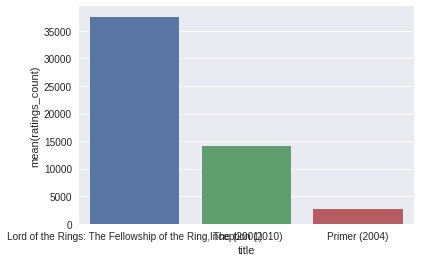

In [ ]:
sns.barplot(x=sample_movies.title, 
            y=sample_movies.ratings_count)

In [ ]:
long_tail_data = popularity.copy()
long_tail_data = long_tail_data.sort_values('ratings_count', ascending=False)
print(long_tail_data.shape)
print(len(long_tail_data.movieId.unique()))
long_tail_data.head()

(26744, 3)
26744


,title,movieId,ratings_count
18839,Pulp Fiction (1994),296,67310
8726,Forrest Gump (1994),356,66172
20794,"Shawshank Redemption, The (1994)",318,63366
21009,"Silence of the Lambs, The (1991)",593,63299
12657,Jurassic Park (1993),480,59715


In [ ]:
ratings = pd.read_csv("ml-20m/ratings.csv")
ratings.drop('timestamp', axis=1, inplace=True)

In [ ]:
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [ ]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()

In [ ]:
print('number of users: {}\nnumber of movies: {}'.format(n_users, n_movies))

number of users: 138493
number of movies: 26744


In [ ]:
print('sparsity level is {}%'.format(round((1.0 - len(ratings)/float(n_users*n_movies))*100, 4)))

sparsity level is 99.46%


In [ ]:
movie_summary = pd.DataFrame(ratings.groupby('movieId')['rating'].mean())

In [ ]:
movie_summary.head()

,rating
movieId,
1,3.921240
2,3.211977
3,3.151040
4,2.861393
5,3.064592


In [ ]:
movie_summary['num_ratings'] = ratings.groupby('movieId')['rating'].count()

In [ ]:
movie_summary.head()

,rating,num_ratings
movieId,,
1,3.921240,49695
2,3.211977,22243
3,3.151040,12735
4,2.861393,2756
5,3.064592,12161


In [ ]:
movie_summary['num_ratings'].describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: num_ratings, dtype: float64

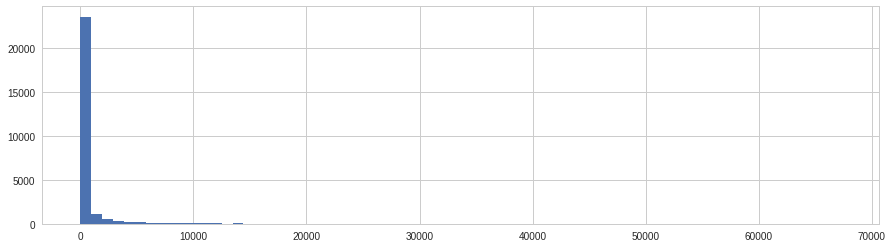

In [ ]:
plt.figure(figsize=(15,4))
movie_summary['num_ratings'].hist(bins=70)

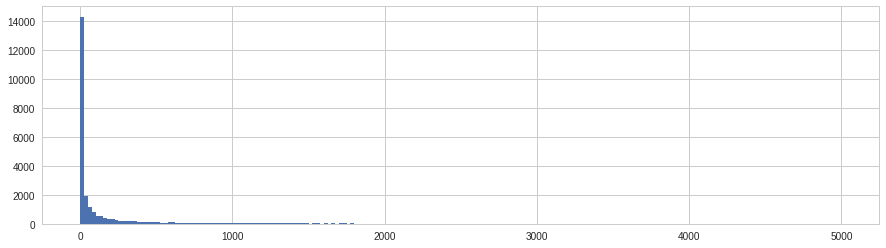

In [ ]:
plt.figure(figsize=(15,4))
movie_summary[movie_summary['num_ratings'] < 5000]['num_ratings'].hist(bins=200)

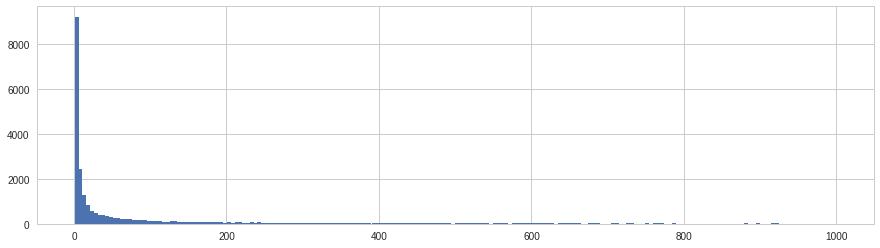

In [ ]:
plt.figure(figsize=(15,4))
movie_summary[movie_summary['num_ratings'] < 1000]['num_ratings'].hist(bins=200)

In [ ]:
(movie_summary['num_ratings'] < 100).sum()

18198

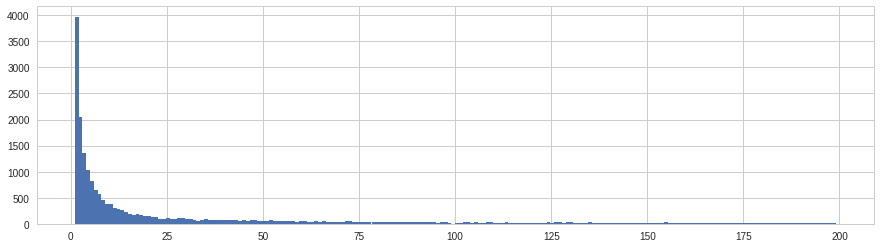

In [ ]:
plt.figure(figsize=(15,4))
movie_summary[movie_summary['num_ratings'] < 200]['num_ratings'].hist(bins=200)

In [ ]:
# how many movies have only 1 rating, could drop all these
print('num movies with 1 rating  = {}'.format((movie_summary['num_ratings'] == 1).sum()))
print('num movies with 0 ratings = {}'.format((movie_summary['num_ratings'] == 0).sum()))

num movies with 1 rating  = 3972
num movies with 0 ratings = 0


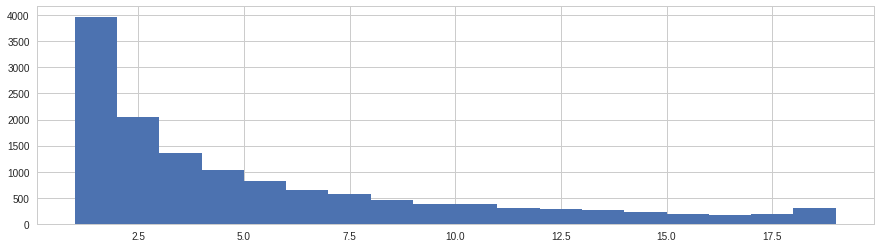

In [ ]:
plt.figure(figsize=(15,4))
movie_summary[movie_summary['num_ratings'] < 20]['num_ratings'].hist(bins=18)

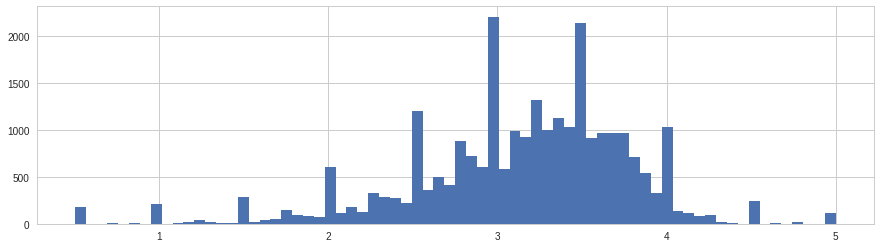

In [ ]:
plt.figure(figsize=(15,4))
movie_summary['rating'].hist(bins=70)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


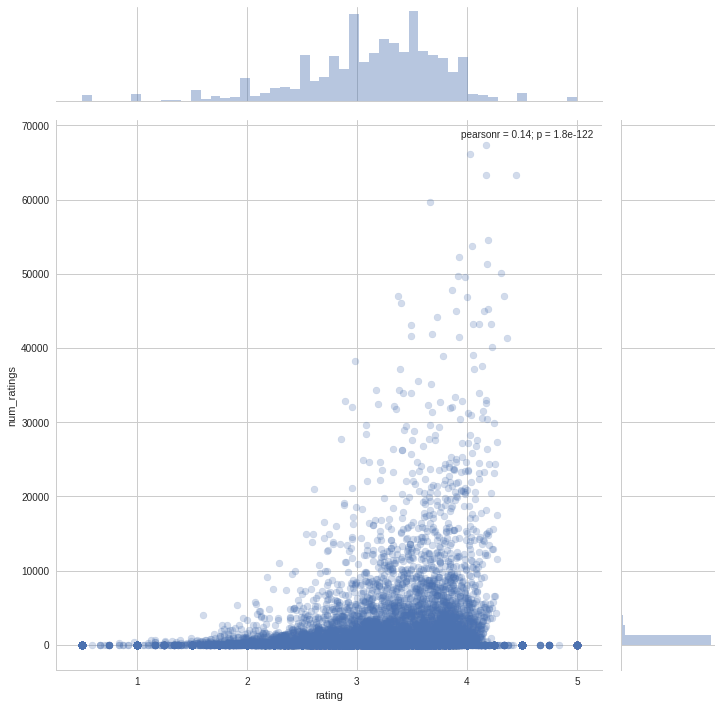

In [ ]:
sns.jointplot(x='rating',y='num_ratings',data=movie_summary,alpha=0.25, size=10)

In [ ]:
user_summary = pd.DataFrame(ratings.groupby('userId')['rating'].count())

In [ ]:
user_summary.columns = ['rating_freq']

In [ ]:
user_summary['rating_mean'] = ratings.groupby('userId')['rating'].mean()

In [ ]:

user_summary.head()

,rating_freq,rating_mean
userId,,
1,175,3.742857
2,61,4.000000
3,187,4.122995
4,28,3.571429
5,66,4.272727


In [ ]:
user_summary.describe()

,rating_freq,rating_mean
count,138493.000000,138493.000000
mean,144.413530,3.627209
std,230.267257,0.443030
min,20.000000,0.500000
25%,35.000000,3.369478
50%,68.000000,3.653846
75%,155.000000,3.923077
max,9254.000000,5.000000


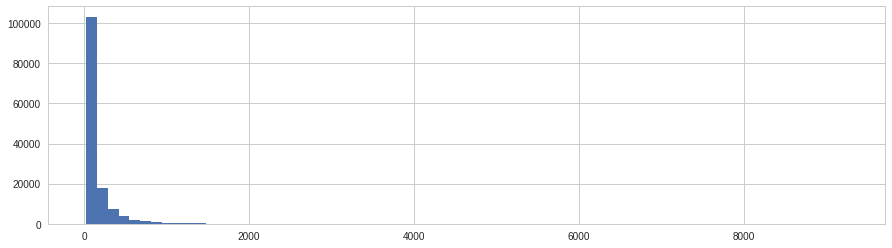

In [ ]:
plt.figure(figsize=(15,4))
user_summary['rating_freq'].hist(bins=70)

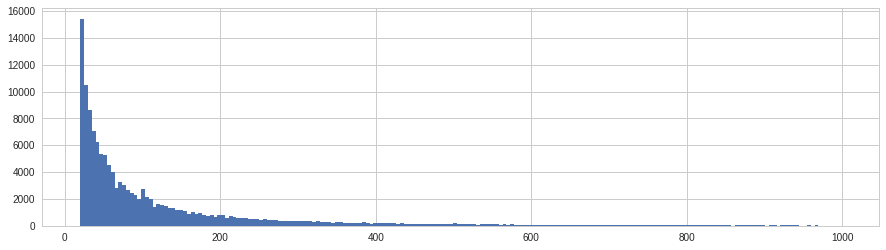

In [ ]:
plt.figure(figsize=(15,4))
user_summary[user_summary['rating_freq'] < 1000]['rating_freq'].hist(bins=200)

In [ ]:
load_cache_extract_datafile("ml-100k.zip", "ml-100k", "http://files.grouplens.org/datasets/movielens/ml-100k.zip")

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# pass in column names for each CSV as the column name is not given in the file and read them using pandas.
# You can check the column names from the readme file

#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

In [ ]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
ratings_train.shape, ratings_test.shape

((90570, 4), (9430, 4))

In [ ]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

In [ ]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
#user similarity and item similarity
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')

In [ ]:
import turicreate
train_data = turicreate.SFrame(ratings_train)
test_data = turicreate.SFrame(ratings_test)

In [ ]:
#ecommend movies based on the most popular choices
popularity_model = turicreate.popularity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating')

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.101489s

90570 observations to process; with 1680 unique items.

In [ ]:
popularity_recomm = popularity_model.recommend(users=[1,2,3,4,5],k=5)
popularity_recomm.print_rows(num_rows=25)

+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    1    |   1599   |  5.0  |  1   |
|    1    |   1201   |  5.0  |  2   |
|    1    |   1189   |  5.0  |  3   |
|    1    |   1122   |  5.0  |  4   |
|    1    |   814    |  5.0  |  5   |
|    2    |   1599   |  5.0  |  1   |
|    2    |   1201   |  5.0  |  2   |
|    2    |   1189   |  5.0  |  3   |
|    2    |   1122   |  5.0  |  4   |
|    2    |   814    |  5.0  |  5   |
|    3    |   1599   |  5.0  |  1   |
|    3    |   1201   |  5.0  |  2   |
|    3    |   1189   |  5.0  |  3   |
|    3    |   1122   |  5.0  |  4   |
|    3    |   814    |  5.0  |  5   |
|    4    |   1599   |  5.0  |  1   |
|    4    |   1201   |  5.0  |  2   |
|    4    |   1189   |  5.0  |  3   |
|    4    |   1122   |  5.0  |  4   |
|    4    |   814    |  5.0  |  5   |
|    5    |   1599   |  5.0  |  1   |
|    5    |   1201   |  5.0  |  2   |
|    5    |   1189   |  5.0  |  3   |
|    5    | 

In [ ]:
#collaborative filtering model
#Training the model
item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='cosine')

#Making recommendations
item_sim_recomm = item_sim_model.recommend(users=[1,2,3,4,5],k=5)
item_sim_recomm.print_rows(num_rows=25)

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.107519s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 9.774ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 16.016ms                            | 0.25             | 6               |

| 248.896ms                           | 100              | 1680            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.268776s

+---------+----------+--------------------+------+
| user_id | movie_id |       score        | rank |
+---------+----------+--------------------+------+
|    1    |   423    | 0.9834008066708805 |  1   |
|    1    |   202    | 0.9495907992352056 |  2   |
|    1    |   655    | 0.7962183331260244 |  3   |
|    1    |   403    | 0.765623665037956  |  4   |
|    1    |   568    | 0.7511795292828829 |  5   |
|    2    |    50    | 1.1256258487701416 |  1   |
|    2    |   181    | 1.0651773168490484 |  2   |
|    2    |    7     | 0.9998190838557023 |  3   |
|    2    |   121    |  0.94162796323116  |  4   |
|    2    |    9     | 0.831989913032605  |  5   |
|    3    |   313    | 0.6353766620159149 |  1   |
|    3    |   328    | 0.6032880300825293 |  2   |
|    3    |   315    | 0.5422587123784152 |  3   |
|    3    |   331    | 0.5355071858926252 |  4   |
|    3    |   332    | 0.5316696112806146 |  5   |
|    4    |    50    | 1.1311477082116264 |  1   |
|    4    |   288    | 1.048715

In [ ]:
#recommendation engine on metrix vectorisation
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
          np.random.shuffle(self.samples)
        self.sgd()
        mse = self.mse()
        training_process.append((i, mse))
        if (i+1) % 20 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [ ]:
R= np.array(ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))

In [ ]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 100 ; error = 337.5855

P x Q:
[[3.65133077 3.52401923 3.51252207 ... 3.54379215 3.55599969 3.54781038]
 [3.67691178 3.50590972 3.4939558  ... 3.50880768 3.55021271 3.54720527]
 [3.61289982 3.45863198 3.44459084 ... 3.47966431 3.48929323 3.49181881]
 ...
 [3.65369294 3.5139047  3.49732689 ... 3.54367061 3.53989932 3.5356316 ]
 [3.6893527  3.54928291 3.52983519 ... 3.5762677  3.58861682 3.58467701]
 [3.63396286 3.47003806 3.48001052 ... 3.51279414 3.51494096 3.51092996]]



In [ ]:
load_cache_extract_datafile("lastfm-dataset-360K.tar", "lastfm-dataset-360K", "https://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/index.html")

In [ ]:
import tarfile
tf = tarfile.open("lastfm-dataset-360K.tar")
tf.extractall()


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# display results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
user_data = pd.read_table('usersha1-artmbid-artname-plays.tsv',
                          header = None, nrows = 2e7,
                          names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols = ['users', 'artist-name', 'plays'])
user_profiles = pd.read_table('usersha1-profile.tsv',
                          header = None,
                          names = ['users', 'gender', 'age', 'country', 'signup'],
                          usecols = ['users', 'country'])

In [ ]:
if user_data['artist-name'].isnull().sum() > 0:
    user_data = user_data.dropna(axis = 0, subset = ['artist-name'])

In [ ]:
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )
artist_plays.head()

,artist-name,total_artist_plays
0,!!!,5802.000
1,!deladap,193.000
2,#####,5141.000
3,#1,155.000
4,$100,75.000


In [ ]:
user_data_with_artist_plays = user_data.merge(artist_plays, left_on = 'artist-name', right_on = 'artist-name', how = 'left')
user_data_with_artist_plays.head()

,users,artist-name,plays,total_artist_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137.000,2220.000
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099.000,42304.000
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897.000,1572.000
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717.000,5503.000
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706.000,2906.000


In [ ]:
print artist_plays['total_artist_plays'].describe()

In [ ]:
print artist_plays['total_artist_plays'].quantile(np.arange(.9, 1, .01)), 

In [ ]:
popularity_threshold = 40000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_popular_artists.head()

,users,artist-name,plays,total_artist_plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099.000,42304.000
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691.000,133910.000
24,00000c289a1829a808ac09c00daf10bc3c4e223b,jack johnson,227.000,78363.000
28,00000c289a1829a808ac09c00daf10bc3c4e223b,the killers,208.000,98650.000
35,00000c289a1829a808ac09c00daf10bc3c4e223b,john mayer,182.000,43216.000


In [ ]:
combined = user_data_popular_artists.merge(user_profiles, left_on = 'users', right_on = 'users', how = 'left')
usa_data = combined.query('country == \'United States\'')
usa_data.head()

,users,artist-name,plays,total_artist_plays,country
20,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407.000,67516.000,United States
21,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213.000,47487.000,United States
22,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203.000,40932.000,United States
23,00007a47085b9aab8af55f52ec8846ac479ac4fe,air,178.000,67218.000,United States
24,00007a47085b9aab8af55f52ec8846ac479ac4fe,portishead,162.000,59781.000,United States


In [ ]:
if not usa_data[usa_data.duplicated(['users', 'artist-name'])].empty:
    initial_rows = usa_data.shape[0]

    print ("Initial dataframe shape {0}".format(usa_data.shape))
    usa_data = usa_data.drop_duplicates(['users', 'artist-name'])
    current_rows = usa_data.shape[0]
    print ("New dataframe shape {0}".format(usa_data.shape))
    print ("Removed {0} rows".format(initial_rows - current_rows))


In [ ]:
wide_artist_data = usa_data.pivot(index = 'artist-name', columns = 'users', values = 'plays').fillna(0)
wide_artist_data_sparse = csr_matrix(wide_artist_data.values)

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_artist_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [ ]:
query_index = np.random.choice(wide_data.shape[0])
distances, indices = model_knn.kneighbors(wide_artist_data.iloc[query_index, :].reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print ("Recommendations for {0}:\n".format(wide_artist_data.index[query_index]))
    else:
        print ("{0}: {1}, with distance of {2}:".format(i, wide_artist_data.index[indices.flatten()[i]], distances.flatten()[i]))

In [ ]:
!pip install fuzzywuzzy[speedup]

In [ ]:

from fuzzywuzzy import fuzz

def print_artist_recommendations(query_artist, artist_plays_matrix, knn_model, k):
    """
    Inputs:
    query_artist: query artist name
    artist_plays_matrix: artist play count dataframe (not the sparse one, the pandas dataframe)
    knn_model: our previously fitted sklearn knn model
    k: the number of nearest neighbors.
    
    Prints: Artist recommendations for the query artist
    Returns: None
    """
    query_index = None
    ratio_tuples = []
    
    for i in artist_plays_matrix.index:
        ratio = fuzz.ratio(i.lower(), query_artist.lower())
        if ratio >= 75:
            current_query_index = artist_plays_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
    
    print ("Possible matches: {0}\n".format([(x[0], x[1]) for x in ratio_tuples]))
    
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print ("Your artist didnt match any artists in the data. Try again")
        return None
    
    distances, indices = knn_model.kneighbors(artist_plays_matrix.iloc[query_index, :].reshape(1, -1), n_neighbors = k + 1)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print ("Recommendations for {0}:\n".format(artist_plays_matrix.index[query_index]))
        else:
            print ("{0}: {1}, with distance of {2}:".format(i, artist_plays_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

    return None

In [ ]:
print_artist_recommendations('red hot chili peppers', wide_artist_data_zero_one, model_nn_binary, k = 10)

In [ ]:
print_artist_recommendations('arctic monkeys', wide_artist_data_zero_one, model_nn_binary, k = 10)